In [2]:
import tensorflow as tf
import keras_cv
import keras

import matplotlib.pyplot as plt
import numpy as np
import os
import glob

from PIL import Image, ImageDraw

from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
from keras_cv.visualization import plot_bounding_box_gallery

from keras_cv.metrics import BoxCOCOMetrics

2025-09-10 15:29:04.497333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757510944.511964  316465 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757510944.516539  316465 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757510944.528283  316465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757510944.528297  316465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757510944.528298  316465 computation_placer.cc:177] computation placer alr

In [3]:
! ls MAGIC-IR-Cam-2/data.yaml

MAGIC-IR-Cam-2/data.yaml


In [3]:
BATCH_SIZE = 8
IMG_SIZE = (640, 640) # Zdefiniuj stały rozmiar obrazu

# Inicjalizuj warstwę do zmiany rozmiaru raz, aby była bardziej wydajna
resizing_layer = keras_cv.layers.Resizing(
    height=IMG_SIZE[0],
    width=IMG_SIZE[1],
    pad_to_aspect_ratio=True, # Utrzymuje proporcje, dodając czarne pasy
    bounding_box_format="xywh"
)

def apply_resizing(data):
    """Pomocnicza funkcja do zastosowania zmiany rozmiaru."""
    return resizing_layer(data)

I0000 00:00:1757510956.050053  316465 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8056 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [4]:
def load_and_preprocess(image_path, annotation_path):
    """
    Wczytuje obraz i jego adnotacje w formacie YOLO, a następnie
    konwertuje je do formatu wymaganego przez KerasCV.
    """
    # === Krok 1: Wczytaj i zdekoduj obraz ===
    image_bytes = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    
    # Pobierz wymiary obrazu, które są niezbędne do denormalizacji
    image_shape = tf.shape(image)
    img_height = tf.cast(image_shape[0], tf.float32)
    img_width = tf.cast(image_shape[1], tf.float32)

    # === Krok 2: Wczytaj i sparsuj plik z adnotacjami ===
    # Wczytaj cały plik tekstowy
    annotation_bytes = tf.io.read_file(annotation_path)
    # Rozdziel plik na osobne linie, usuwając puste
    lines = tf.strings.split(annotation_bytes, sep='\n')
    lines = tf.reshape(lines, [-1,]) # Spłaszcz do 1D
    lines = tf.strings.strip(lines) # Usuń białe znaki
    lines = lines[tf.strings.length(lines) > 0] # Usuń puste linie
    
    # Przygotuj tensory na wyniki
    boxes = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    classes = tf.TensorArray(tf.float32, size=0, dynamic_size=True)

    # Przejdź przez każdą linię w pliku adnotacji
    for i in tf.range(tf.shape(lines)[0]):
        line = lines[i]
        parts = tf.strings.split(line, ' ')
        
        # Konwertuj części na liczby
        class_id = tf.strings.to_number(parts[0], out_type=tf.float32)
        x_center_norm = tf.strings.to_number(parts[1], out_type=tf.float32)
        y_center_norm = tf.strings.to_number(parts[2], out_type=tf.float32)
        width_norm = tf.strings.to_number(parts[3], out_type=tf.float32)
        height_norm = tf.strings.to_number(parts[4], out_type=tf.float32)
        
        # === Krok 3: Konwertuj współrzędne z YOLO na format KerasCV (xywh w pikselach) ===
        # Denormalizacja
        box_width = width_norm * img_width
        box_height = height_norm * img_height
        x_center = x_center_norm * img_width
        y_center = y_center_norm * img_height
        
        # Obliczanie lewego górnego rogu (x, y)
        x_min = x_center - (box_width / 2.0)
        y_min = y_center - (box_height / 2.0)
        
        # Dodaj wyniki do tablic
        boxes = boxes.write(i, [x_min, y_min, box_width, box_height])
        classes = classes.write(i, class_id)

    # Zbuduj ostateczne tensory z tablic
    final_boxes = boxes.stack()
    final_classes = classes.stack()

    return {"images": image, "bounding_boxes": {"boxes": final_boxes, "classes": final_classes}}

In [4]:
! ls MAGIC-IR-Cam-2/train

images	labels	labels.cache


In [7]:
! ls MAGIC-IR-Cam-2/train/images | head 

IRCamM1T20250620_070000M_jpg.rf.f56d92913681cd9ccfd6cfe0efe981df.jpg
IRCamM1T20250620_074000M_jpg.rf.9bb1e15cad99f4b9bbba3959cc6570ff.jpg
IRCamM1T20250620_102000M_jpg.rf.9bcb39adb282bf9266bd08ed4a037ce5.jpg
IRCamM1T20250620_120000M_jpg.rf.565b3ef036dd0c192003c940738698ba.jpg
IRCamM1T20250620_124000M_jpg.rf.e57d61ce116e417ac453cc323a91fc52.jpg
IRCamM1T20250620_160000M_jpg.rf.4f715e9e0d4bf1911ea2a5104b0ebd28.jpg
IRCamM1T20250620_163000M_jpg.rf.ab82551391e9316c856a1ef559d1423b.jpg
IRCamM1T20250620_175000M_jpg.rf.8c300fc02d85e6160a8879996f49c07c.jpg
IRCamM1T20250620_185000M_jpg.rf.77756cc935585e4fb3b74c7f3548dc47.jpg
IRCamM1T20250621_094000M_jpg.rf.79b567d7808f8c394cd3b7232fcbb163.jpg


In [11]:
obj = load_and_preprocess(
    "MAGIC-IR-Cam-2/train/images/IRCamM1T20250620_070000M_jpg.rf.f56d92913681cd9ccfd6cfe0efe981df.jpg", 
    "MAGIC-IR-Cam-2/train/labels/IRCamM1T20250620_070000M_jpg.rf.f56d92913681cd9ccfd6cfe0efe981df.txt"
)

In [13]:
obj.keys()

dict_keys(['images', 'bounding_boxes'])

In [14]:
tf.data.AUTOTUNE

-1

In [21]:
data_dir = "MAGIC-IR-Cam-2/train/"

image_paths = [os.path.join(data_dir, "images", f) for f in os.listdir(os.path.join(data_dir, "images"))]
annotation_paths = [os.path.join(data_dir, "labels", f.replace(".jpg", ".txt")) for f in os.listdir(os.path.join(data_dir, "images"))]

print(f"Znaleziono {len(image_paths)} obrazów")

Znaleziono 72 obrazów


In [22]:
path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, annotation_paths))

In [29]:
processed_dataset = path_dataset.map(
    load_and_preprocess, 
    num_parallel_calls=tf.data.AUTOTUNE
)

In [31]:
# Teraz 'processed_dataset' zawiera wczytane i przetworzone obrazy oraz adnotacje,
# gotowe do dalszych kroków, takich jak batchowanie i trening.
# Możesz sprawdzić jeden element:
for sample in processed_dataset.take(4):
    print("Klucze:", sample.keys())
    print("Kształt obrazu:", sample["images"].shape)
    print("Kształt boxów:", sample["bounding_boxes"]["boxes"].shape)
    print("Kształt klas:", sample["bounding_boxes"]["classes"].shape)

Klucze: dict_keys(['images', 'bounding_boxes'])
Kształt obrazu: (640, 640, 3)
Kształt boxów: (3, 4)
Kształt klas: (3,)
Klucze: dict_keys(['images', 'bounding_boxes'])
Kształt obrazu: (640, 640, 3)
Kształt boxów: (4, 4)
Kształt klas: (4,)
Klucze: dict_keys(['images', 'bounding_boxes'])
Kształt obrazu: (640, 640, 3)
Kształt boxów: (2, 4)
Kształt klas: (2,)
Klucze: dict_keys(['images', 'bounding_boxes'])
Kształt obrazu: (640, 640, 3)
Kształt boxów: (2, 4)
Kształt klas: (2,)


In [5]:
BATCH_SIZE = 8
IMG_SIZE = (640, 640) # Zdefiniuj stały rozmiar obrazu

# Inicjalizuj warstwę do zmiany rozmiaru raz, aby była bardziej wydajna
resizing_layer = keras_cv.layers.Resizing(
    height=IMG_SIZE[0],
    width=IMG_SIZE[1],
    pad_to_aspect_ratio=True, # Utrzymuje proporcje, dodając czarne pasy
    bounding_box_format="xywh"
)

def apply_resizing(data):
    """Pomocnicza funkcja do zastosowania zmiany rozmiaru."""
    return resizing_layer(data)

In [6]:
def apply_resizing(data):
    images = data["images"]
    bounding_boxes = data["bounding_boxes"]
    # Zmieniamy rozmiar tylko obrazów, etykiety są dostosowywane automatycznie
    resized_images = resizing_layer({"images": images, "bounding_boxes": bounding_boxes})
    return {"images": resized_images["images"], "bounding_boxes": resized_images["bounding_boxes"]}

def create_dataset(data_dir, batch_size):
    image_dir = os.path.join(data_dir, "images")
    label_dir = os.path.join(data_dir, "labels")
    
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_paths = [os.path.join(image_dir, f) for f in image_files]
    annotation_paths = [os.path.join(label_dir, f.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')) for f in image_files]

    path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, annotation_paths))
    
    processed_dataset = path_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    # === ZMIANA 1: Użyj .padded_batch() ===
    # Definiujemy kształty, do których będziemy dopełniać. `None` oznacza zmienny rozmiar.
    padded_shapes = {
        "images": [None, None, 3],
        "bounding_boxes": {
            "boxes": [None, 4],
            "classes": [None],
        }
    }
    processed_dataset = processed_dataset.padded_batch(
        batch_size, padded_shapes=padded_shapes, drop_remainder=True
    )
    
    # Stosujemy zmianę rozmiaru po stworzeniu paczki
    processed_dataset = processed_dataset.map(apply_resizing, num_parallel_calls=tf.data.AUTOTUNE)
    
    # === ZMIANA 2: Przekształć słownik na krotkę (x, y) ===
    # model.fit() oczekuje danych w formacie (dane_wejściowe, etykiety)
    processed_dataset = processed_dataset.map(
        lambda data: (data["images"], data["bounding_boxes"]),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    processed_dataset = processed_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return processed_dataset

In [8]:
train_directory = "MAGIC-IR-Cam-2/train"
valid_directory = "MAGIC-IR-Cam-2/valid"

train_ds = create_dataset(train_directory, batch_size=BATCH_SIZE)
val_ds = create_dataset(valid_directory, batch_size=BATCH_SIZE)

print(f"\nStworzono zbiór treningowy: {train_ds}")
print(f"Stworzono zbiór walidacyjny: {val_ds}")


Stworzono zbiór treningowy: <_PrefetchDataset element_spec=(TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None), {'boxes': RaggedTensorSpec(TensorShape([8, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64)})>
Stworzono zbiór walidacyjny: <_PrefetchDataset element_spec=(TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None), {'boxes': RaggedTensorSpec(TensorShape([8, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64)})>


In [14]:
NUM_CLASSES = 1
BOUNDING_BOX_FORMAT = "xywh"
PRESET = "resnet50_imagenet"

model = keras_cv.models.RetinaNet.from_preset(
    PRESET,
    num_classes=NUM_CLASSES,
    bounding_box_format = BOUNDING_BOX_FORMAT
)

In [17]:
optimizer = keras.optimizers.Adam(
    learning_rate = 0.0001,
    global_clipnorm=10.0
)

model.compile(
    optimizer = optimizer,
    classification_loss = "focal", # funckja straty dla detekcji
    box_loss = "smoothl1", # funkcja straty dla regresji bounding boxow
    jit_compile=False # <-- DODAJ TĘ LINIĘ
)

In [18]:
# Callback do zapisywania najlepszej wersji modelu
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True
)

# Callback do wczesnego zatrzymywania treningu
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, # Zatrzymaj, jeśli przez 5 epok nie ma poprawy
    restore_best_weights=True
)

# Uruchom trening!
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # Możesz dostosować liczbę epok
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


I0000 00:00:1757344857.050998  304239 cuda_dnn.cc:529] Loaded cuDNN version 90501


8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - box_loss: 0.5423 - classification_loss: 0.8617 - loss: 1.4040 - val_box_loss: 0.3288 - val_classification_loss: 0.2332 - val_loss: 0.5619
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step - box_loss: 0.2576 - classification_loss: 0.1524 - loss: 0.4099 - val_box_loss: 0.1607 - val_classification_loss: 0.0991 - val_loss: 0.2598
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - box_loss: 0.1218 - classification_loss: 0.0478 - loss: 0.1696 - val_box_loss: 0.0889 - val_classification_loss: 0.0592 - val_loss: 0.1482
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 688ms/step - box_loss: 0.0803 - classification_loss: 0.0275 - loss: 0.1079 - val_box_loss: 0.0805 - val_classification_loss: 0.0666 - val_loss: 0.1471
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 687ms/step - box_loss: 0.0595 - classification_loss: 0.0201 - loss: 0.0796 - val_box_loss: 0.0935 - val_classification_loss: 0.0437 - val_loss: 0.1371
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 683ms/step - box_loss: 0

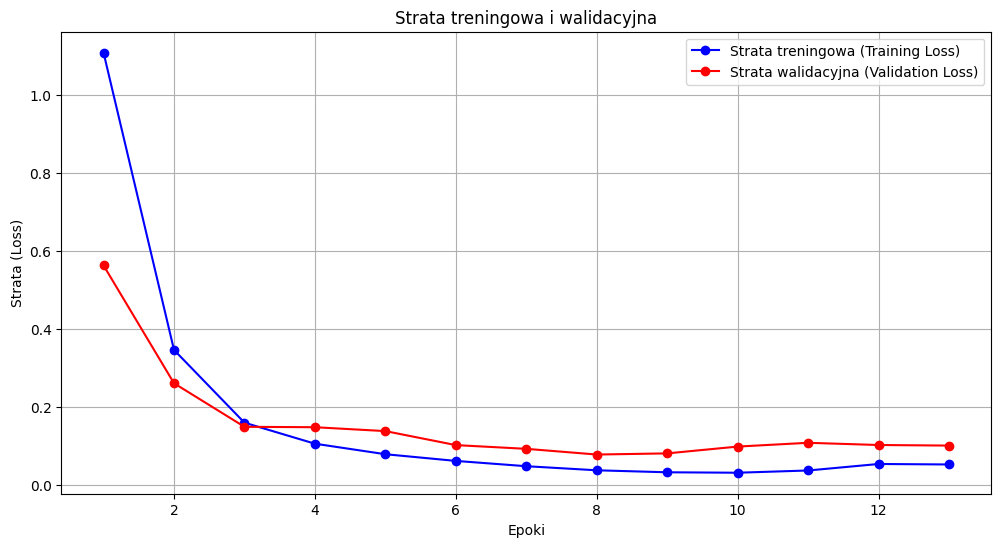

In [19]:
# Pobierz dane z obiektu 'history'
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_range = range(1, len(train_loss) + 1)

# Stwórz wykres
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, 'bo-', label='Strata treningowa (Training Loss)')
plt.plot(epochs_range, val_loss, 'ro-', label='Strata walidacyjna (Validation Loss)')
plt.title('Strata treningowa i walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata (Loss)')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# === Krok 1: Wczytaj najlepszą wersję zapisanego modelu ===
# Upewnij się, że KerasCV jest zaimportowane, aby Keras wiedział o niestandardowych warstwach
loaded_model = keras.models.load_model('best_model.keras')

/home/pgliwny/anaconda3/envs/cv/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [23]:
! ls MAGIC-IR-Cam-2/test

images	labels


In [6]:
new_image_path = "MAGIC-IR-Cam-2/test/images/IRCamM1T20250620_093000M_jpg.rf.ad1d11c0d1c4d8ed9766fe44c1cb747f.jpg"
# Wczytaj obraz
image = tf.io.read_file(new_image_path)
image = tf.image.decode_jpeg(image, channels=3)

# Dodaj wymiar batcha (model oczekuje paczki obrazów, a nie pojedynczego)
image_batch = np.expand_dims(image, axis=0)

# Użyj TEJ SAMEJ warstwy 'resizing_layer', której używałeś w potoku danych
# Musi być ona zdefiniowana tak samo jak wcześniej
# IMG_SIZE = (640, 640)
# resizing_layer = keras_cv.layers.Resizing(...)
prepared_batch = resizing_layer({"images": image_batch})

/home/pgliwny/anaconda3/envs/cv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)
I0000 00:00:1757510986.116174  316583 service.cc:152] XLA service 0x3f0a1750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757510986.116206  316583 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-09-10 15:29:46.257281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757510986.751776  316583 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1757510991.016959  316583 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


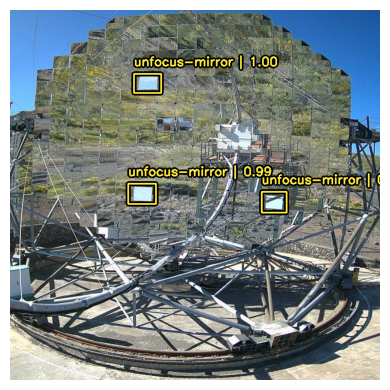

In [7]:
# === Krok 3: Dokonaj predykcji ===
predictions = loaded_model.predict(prepared_batch['images'])

# === Krok 4: Wizualizuj wyniki ===
# KerasCV ma świetną funkcję do rysowania wyników detekcji
plot_bounding_box_gallery(
    prepared_batch['images'],
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_pred=predictions,
    scale=4,
    rows=1,
    cols=1,
    show=True,
    font_scale=0.7,
    # Mapa indeksów na nazwy klas (masz jedną klasę o indeksie 0)
    class_mapping={0: "unfocus-mirror"} 
)

In [28]:
predictions['boxes'].shape

(1, 100, 4)

In [12]:
loaded_model.compile(
    # Metryka do obliczania mAP i innych wskaźników COCO
    classification_loss = "focal",
    box_loss = "smoothl1",
    metrics=[
        BoxCOCOMetrics(
            bounding_box_format="xywh",
            evaluate_freq=1, # Obliczaj metryki dla każdej paczki
        )
    ],
    jit_compile=False # Pamiętaj o wyłączeniu XLA
)

In [13]:
# Uruchom ewaluację
evaluation_results = loaded_model.evaluate(val_ds)

# Wyświetl wyniki
print("Wyniki ewaluacji:")
print(evaluation_results)

/home/pgliwny/anaconda3/envs/cv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(8, 640, 640, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - MaP: 0.7269 - MaP@[IoU=50]: 1.0000 - MaP@[IoU=75]: 0.9412 - MaP@[area=large]: 0.0000e+00 - MaP@[area=medium]: 0.7269 - MaP@[area=small]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - Recall@[area=medium]: 0.7556 - Recall@[area=small]: 0.0000e+00 - Recall@[max_detections=100]: 0.7556 - Recall@[max_detections=10]: 0.7556 - Recall@[max_detections=1]: 0.2725 - box_loss: 0.0620 - classification_loss: 0.0160 - loss: 0.0780
Wyniki ewaluacji:
[0.07706204056739807, 0.06141873449087143, 0.015643302351236343, 0.7282359004020691, 1.0, 0.9437294006347656, 0.0, 0.7282359004020691, 0.0, 0.0, 0.7583333253860474, 0.0, 0.7583333253860474, 0.7583333253860474, 0.2562499940395355]


## Zrozumienie metryk COCO 📈
Wynik evaluation_results będzie słownikiem zawierającym różne metryki. Oto najważniejsze z nich:

MaP (mean Average Precision @ IoU=.50:.95): To główna i najważniejsza metryka. Mierzy średnią precyzję modelu przy różnych progach "trafienia" (IoU od 50% do 95%). Im wyższa, tym lepszy model.

MaP@.50: Popularna metryka, która mierzy precyzję przy łatwiejszym kryterium (IoU równe 50%).

MaP@.75: Surowsza metryka, mierząca precyzję przy progu IoU równym 75%.

Recall (Czułość): Mówi o tym, jak dobrze model radzi sobie ze znajdowaniem wszystkich istniejących obiektów

In [8]:
images_test = glob.glob("MAGIC-IR-Cam-2/test/images/*")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


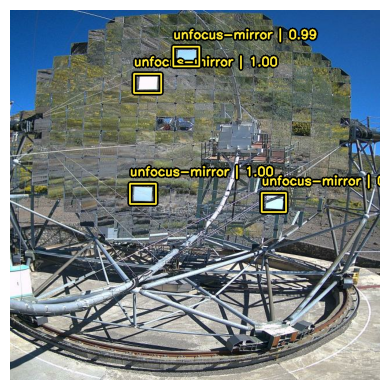

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


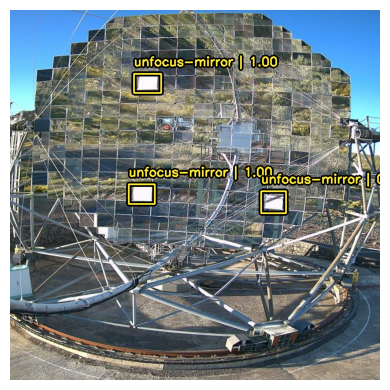

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


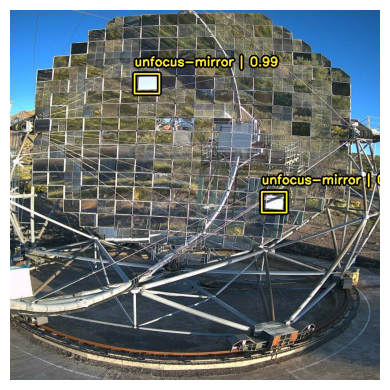

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


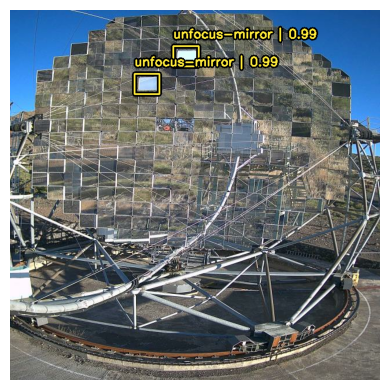

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


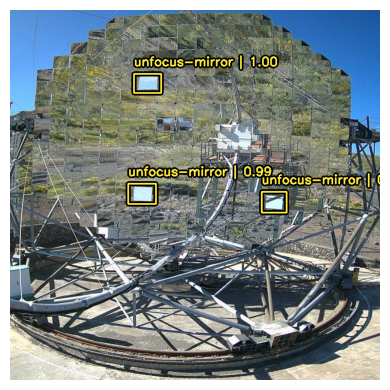

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


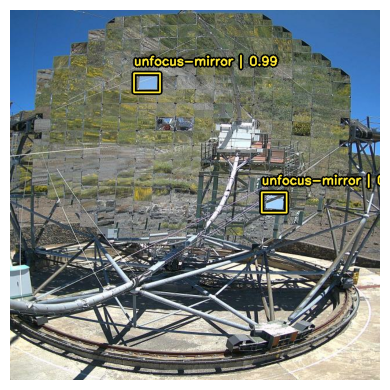

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


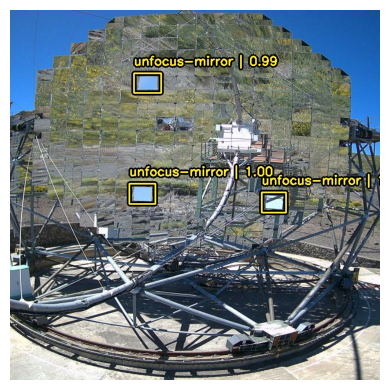

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


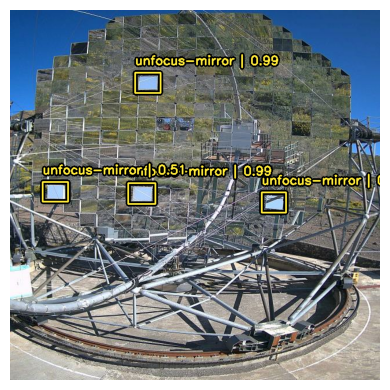

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


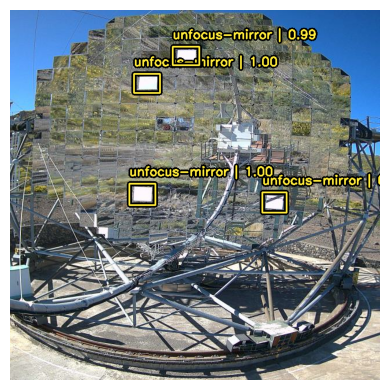

In [9]:
for new_image_path in images_test:

    # Wczytaj obraz
    image = tf.io.read_file(new_image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Dodaj wymiar batcha (model oczekuje paczki obrazów, a nie pojedynczego)
    image_batch = np.expand_dims(image, axis=0)
    
    # Użyj TEJ SAMEJ warstwy 'resizing_layer', której używałeś w potoku danych
    # Musi być ona zdefiniowana tak samo jak wcześniej
    # IMG_SIZE = (640, 640)
    # resizing_layer = keras_cv.layers.Resizing(...)
    prepared_batch = resizing_layer({"images": image_batch})

    # === Krok 3: Dokonaj predykcji ===
    predictions = loaded_model.predict(prepared_batch['images'])
    
    # === Krok 4: Wizualizuj wyniki ===
    # KerasCV ma świetną funkcję do rysowania wyników detekcji
    plot_bounding_box_gallery(
        prepared_batch['images'],
        value_range=(0, 255),
        bounding_box_format="xywh",
        y_pred=predictions,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        # Mapa indeksów na nazwy klas (masz jedną klasę o indeksie 0)
        class_mapping={0: "unfocus-mirror"} 
    )